In [1]:
import timm
import numpy as np
import torch
import matplotlib.pyplot as plt
import transformers
import csv
import pandas as pd
import seaborn as sns
from transformers import pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from PIL import Image

# Init

In [2]:
cd imagenet-autoencoder/

c:\Users\seung\Desktop\auto_image\Mixed-AutoEncoder\imagenet-autoencoder


In [3]:
data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')
label = data['class']
num_class = len(data['class'].unique())
names = ['fire','fogsmog', 'lightning', 'rain', 'sandstorm','snow']
data['name'] = [names[i] for i in data['class']]

C:\Users\seung\AppData\Local\Temp\ipykernel_4696\228420673.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')


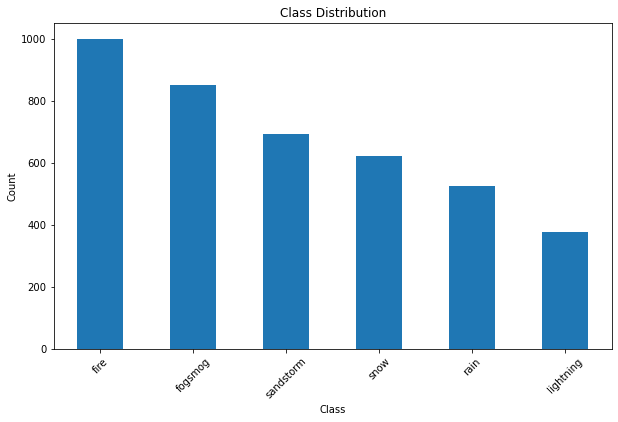

In [4]:
class_counts = data['name'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Read Images
image_list = list()
for path in data['path']:
    image = Image.open(path)
    image_list.append(image)
len(image_list)

4067

In [18]:
class kmeans_estimation():
    def __init__(self, input_vector, label):
        self.input_vector = input_vector
        self.label = label
    def evaluate_pca(self):
        pca=PCA()
        pca.fit(self.input_vector)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        
    def kmeans_with_pca(self,num_components, num_cluster, round = 1, algorithm="auto"):
        self.pca = PCA(n_components=num_components)
        latent_vector = self.pca.fit_transform(self.input_vector)
        self.kmeans = KMeans(n_clusters = num_cluster, n_init = round, algorithm=algorithm)
        y_kmeans = self.kmeans.fit_predict(latent_vector)
        self.print_confusion_matrix(self.label, y_kmeans)
    
    def kmeans_with_parameter(self,parameter: np.ndarray):
        H, W = parameter.shape
        self.kmeans = KMeans(n_clusters= H, init = parameter)
        self.pca = PCA(n_components= W)
        latent_vector = self.pca.fit_transform(self.input_vector)
        y_kmeans = self.kmeans.fit_predict(latent_vector)
        self.print_confusion_matrix(self.label,y_kmeans)
    
    def print_confusion_matrix(self, label, pred):
        conf_matrix = confusion_matrix(label, pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted Label')
        plt.ylabel('class')

    def save_centerpoint(self, file_name : str):
        target = self.kmeans.cluster_centers_
        index = np.arange(len(target)).reshape(-1, 1)
        result = np.hstack((index, target))
        np.savetxt(f'{file_name}.txt', result, fmt='%d' + '\t%.8f' * target.shape[1], delimiter='\t')

    def get_kmeans(self):
        """
        return kmeans object
        """
        return self.kmeans
    def get_pca(self):
        """
        return pca object
        """
        return self.pca

# ViT224

In [27]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_224= pipeline(task="image-feature-extraction", model_name="vit_base_patch16_224", device=DEVICE, pool=True)
#Start Inference
outputs = pipe_224(image_list)
#Change shapes 
np_output = np.array(outputs)
o0 = np_output.reshape((np_output.shape[0],-1))
o0.shape

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(4067, 768)

In [34]:
center_data = pd.read_table("./cluster_centers_vit224.txt",header=None)
data_array = center_data.iloc[:, 1:].values
data_array.shape

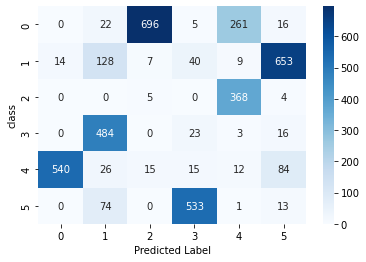

In [68]:
vit_224_0 = kmeans_estimation(o0,label)
vit_224_0.kmeans_with_pca(700,6)
cp = vit_224_0.get_kmeans().cluster_centers_

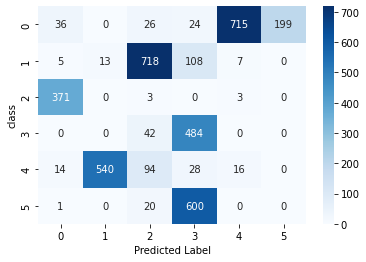

In [135]:
vit_224_1 = kmeans_estimation(o0, label)
vit_224_1.kmeans_with_pca(700,6,100)
# vit_224_1.kmeans_with_parameter(parameter=cp, round= 10)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


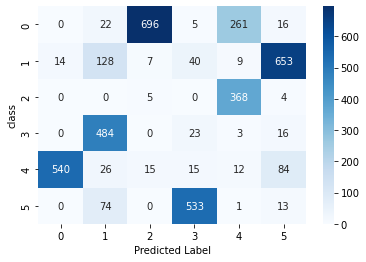

In [136]:
vit_224_1 = kmeans_estimation(o0, label)
# vit_224_1.kmeans_with_pca(700,6,40)
vit_224_1.kmeans_with_parameter(parameter=cp)

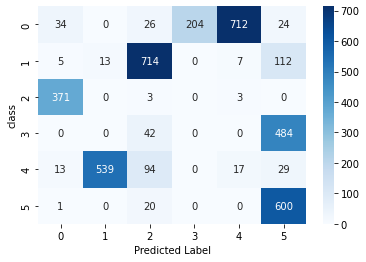

In [181]:
vit_224_2 = kmeans_estimation(o0, label)
vit_224_2.kmeans_with_pca(700, 6,15,"elkan")

# ViT 384

In [10]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-384')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384')

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_384= pipeline(task="image-feature-extraction", model = model,image_processor = feature_extractor ,device=DEVICE)
#Start Inference
o1 = pipe_384(image_list)
#Change shapes 
o1 = np.array(o1)
o1 = o1.reshape((o1.shape[0],-1))
o1.shape

(4067, 1000)

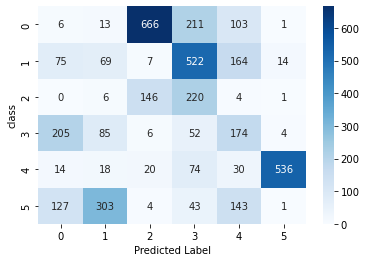

In [26]:
vit_384_0 = kmeans_estimation(o1,label)
vit_384_0.kmeans_with_pca(1000,6,round = 450 ,algorithm="auto")

# Different Algorithms

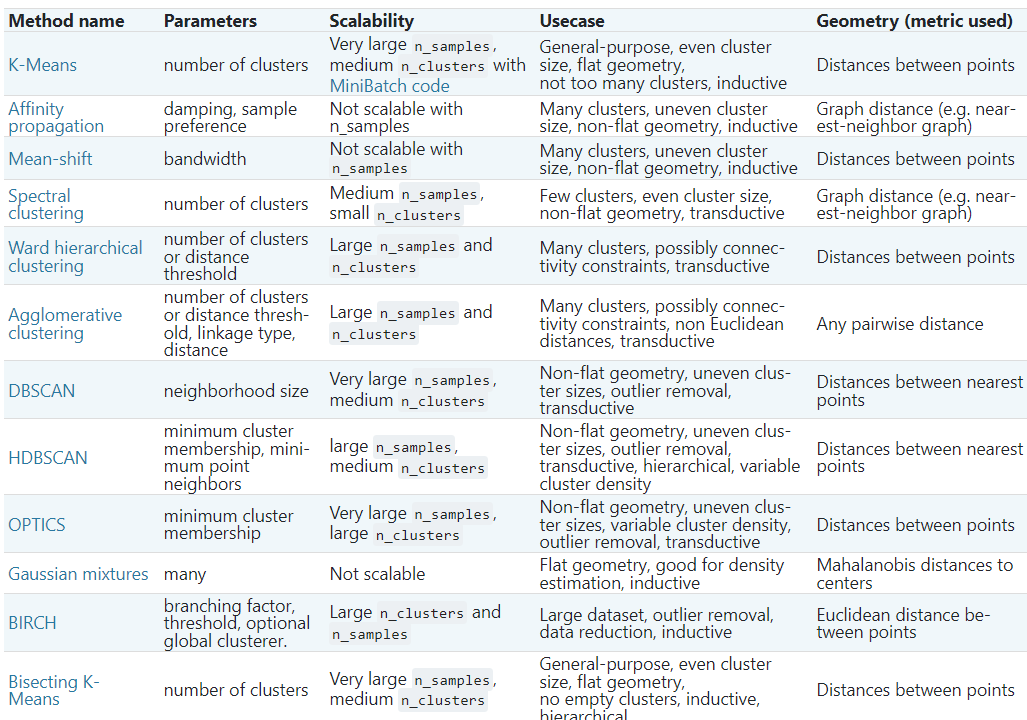

In [28]:
o1.shape

(4067, 1000)

In [32]:
pca_224 = PCA(n_components= 300)
pca_384 = PCA(n_components = 300)
op_0 =pca_224.fit_transform(o0)
op_1 = pca_384.fit_transform(o1)